Done Importing
=== Uint8 Label Array Inspection ===
Shape        : (2048, 2048)
Data type    : uint8
Memory       : 4194304 bytes
Min | Max    : 0 | 9

Pixel counts per label:
  Background : 4189428 px
  Cell 1     : 364 px
  Cell 2     : 623 px
  Cell 3     : 185 px
  Cell 4     : 247 px
  Cell 5     : 441 px
  Cell 6     : 350 px
  Cell 7     : 278 px
  Cell 8     : 1872 px
  Cell 9     : 516 px

Sample (top‑left 10×10) of raw values:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Saved raw binary: C:\Users\User\Documents\GitHub\yeastReverseImageSegmentation\dump0\canvas_tester_mask.uint8
Saved NumPy array: C:\Users\User\Documents\GitHub\yeastReverseImageSegmentation\dump0\canvas_tester_mask.npy
Saved PNG: C:\Users\User\Documents\GitHub\yeastReverseImageSegmentation\dump0\canvas_tester_mask_labels.png
S

C:\Users\User\AppData\Local\Temp\ipykernel_14764\1281607214.py:748: RuntimeWarning: invalid value encountered in divide
  img = np.where(overlap_count > 0, min_vals / overlap_count, 0.0).astype(np.float32)
C:\Users\User\anaconda3\envs\envYeast\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 8192 or by setting the environment variable OMP_NUM_THREADS=6
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..53199].


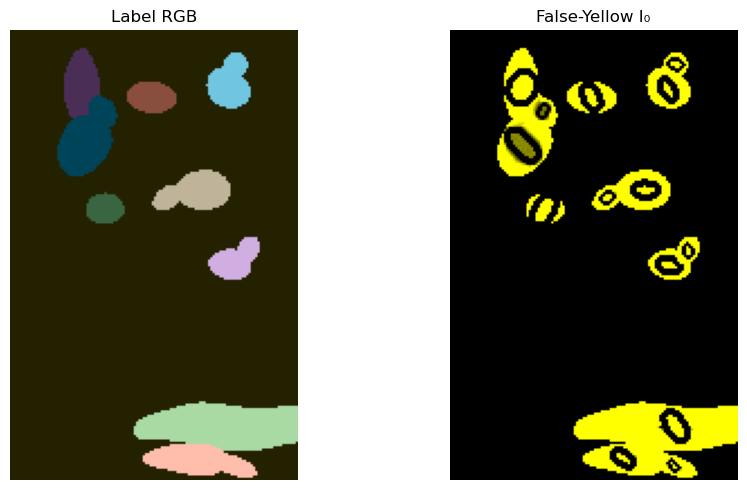

Saved demo_fluor.tiff (uint16) and vis_yellow.png - run time 50.53s


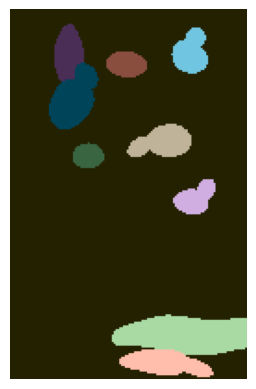

In [5]:
from typing import Any

import imageio
import time
import imageio.v2 as imageio  #imageio‑v3 friendly import
import numpy as np
from    noise   import  pnoise2
from numpy import ndarray, dtype, float64
from skimage.draw import ellipse
from    scipy.signal import fftconvolve
import error_minimization
from    pathlib import  Path


import psfmodels    as psfm
from scipy.ndimage import distance_transform_edt,   center_of_mass, binary_erosion, gaussian_filter, sobel
import os
import cv2

import math
import ellipseExamplesIo
import ellipseMath

print("Done Importing")
from scipy import ndimage
from perlin_numpy import generate_perlin_noise_2d
from ellipseMath import _fit_periods



from ellipseExamplesIo import visualize_uint8_labels
import matplotlib.pyplot as plt, numpy as np





import time
import  matplotlib.pyplot as plt
from numpy.random import default_rng
import tifffile
from scipy import ndimage                                     #PSF blur
from perlin_numpy import generate_perlin_noise_2d             #Perlin

import ellipseMath, ellipseExamplesIo
from ellipseMath import     (_fit_periods,
                            ellipse_params_to_general_form,
                            create_ellipse_mask_vectorized_perturbed2,
                             center_offset,edge_mask_np)
from ellipseExamplesIo import   (visualize_uint8_labels,
                                save_uint8_labels,
                                n_spaced_lab,
                                order_for_gradient,
                                gradient_palette,
                                colormap_for_cells,
                                palette_to_strip,
                                colormap_for_cells,
                                canvas_slicer)


_FALSE_YELLOW   =   tuple(int("#CFCF00".lstrip("#")[i:i+2], 16) for i in (0, 2, 4))

notebook_directory = os.getcwd()

import numpy as np
from numpy.random import default_rng
rng_global = default_rng()

#-------------------------------------------------------------------------
#Helper 1 ─ choose where & how the bud attaches
#-------------------------------------------------------------------------
def add_bud_random_rotation(parent_axes, parent_center, *,
                             bud_ratio: float = 0.6,
                             bud_offset: float = 0.15,
                             rng=rng_global):
    """
    Return (bud_center_yx, bud_axes, bud_rot_deg).

    The bud centre is placed tangentially at a random angle on the mother
    ellipse, then shifted *outward* by `bud_offset * max(a_p,b_p)`.
    Bud semi‑axes = `bud_ratio * parent_axes`.
    Rotation ∈ [0°,180°) to break alignment symmetry.

    Notes
    -----
    • `bud_ratio`  ≈ 0.5-0.7 matches measured daughter : mother volume
      ratios 0.5‑0.7 in *S. cerevisiae*:.
    • `bud_offset` ≥ `bud_ratio·a_p/max` guarantees the bud does **not**
      cross the mother’s far side.
    """
    eps =   np.finfo(np.float32).eps
    delta_deg_max: float = 23.0


    parent_center_y, parent_center_x   = parent_center
    a_p, b_p = parent_axes
    a_semi_bud, b_semi_bud   = np.array(parent_axes) * bud_ratio
    c_bud        = math.hypot(a_semi_bud, b_semi_bud)

    #random attachment angle on mother perimeter

    phi = rng.uniform(0.0, 2*np.pi)
    Px = parent_center_x + a_p * math.cos(phi)
    Py = parent_center_y + b_p * math.sin(phi)
    #outward normal
    n_hat = np.array([math.cos(phi)/a_p, math.sin(phi)/b_p])
    n_hat /= np.linalg.norm(n_hat)

    #andom rotation around the neck
    theta_0 = math.degrees(math.atan2(n_hat[1], n_hat[0]))
    theta  = theta_0 + rng.uniform(-delta_deg_max, delta_deg_max)
    theta_rad = math.radians(theta)

    #analytic shift for tangency i hate this as it is numerically v iffy
    ux, uy =  math.cos(theta_rad)*n_hat[0] + math.sin(theta_rad)*n_hat[1], \
             -math.sin(theta_rad)*n_hat[0] + math.cos(theta_rad)*n_hat[1]  #R(-θ) n̂
    denom   = (ux/a_semi_bud)**2 + (uy/b_semi_bud)**2
    s_touch = 1.0 / math.sqrt(denom + eps)  #max_sensible offfset

    sigma_off = s_touch / 1.96                    #2-sided 95 % quantile
    r_off     = np.abs(rng.normal(0.0, sigma_off))
    r_off     = min(r_off, s_touch)               #clamp overshoot

    Cx = Px + r_off * n_hat[0]
    Cy = Py + r_off * n_hat[1]
    """
    y_bound = center_y + a_p * np.sin(phi)
    x_bound = center_x + b_p * np.cos(phi)

    #shift bud centre slightly outward
    shift   = bud_offset * max(a_p, b_p)
    bud_center_y  = y_bound + shift * np.sin(phi)
    bud_center_x  = x_bound + shift * np.cos(phi)

    #scale axes & random own rotation
    a_semi_budud, b_semi_budud = a_p * bud_ratio, b_p * bud_ratio
    bud_rot_deg  = rng.uniform(0.0, 180.0)"""

    return (Cy, Cx), (a_semi_bud, b_semi_bud), theta







def ellipse_mask_rot_jitter(h, w, center, axes, angle_deg: float,
                            *, jitter=0.05, noise_scale=64,
                            seed=None, repeat=True):
    """
    Boolean mask of a rotated ellipse with optional Perlin boundary jitter.

    Parameters
    ----------
    angle_deg : float
        CCW rotation of the bud ellipse.
    jitter : float
        Relative amplitude of Perlin noise perturbation (0 → no wobble).
    noise_scale : int
        Larger -> coarser bumps (Perlin period ≈ `noise_scale` px).
    """
    yy, xx = np.indices((h, w), dtype=np.float32)
    center_y, center_x = center
    a,  b  = axes
    tiny32 = np.finfo(np.float32).tiny
    #convert world offsets -> body frame (x",y")  (StackOverflow rotation)
    dy, dx = yy - center_y, xx - center_x
    phi      = np.deg2rad(angle_deg, dtype=np.float32)
    cosphi, sinphi = np.cos(phi), np.sin(phi)
    x_p = dx * cosphi + dy * sinphi
    y_p = -dx * sinphi + dy * cosphi
    eps32 = np.finfo(np.float32).eps
    #Per‑pixel jitter of axes via Perlin field
    if jitter:

        res_y = _fit_periods(h, noise_scale)  #guarantees h % res_y == 0
        res_x = _fit_periods(w, noise_scale)
        noise = generate_perlin_noise_2d((h, w), (res_y, res_x),
                                         tileable=(repeat, repeat)).astype(np.float32)

        #more numerically stable for extra checks
        scale = math.fma(jitter, noise,1.0)  if hasattr(math, "fma") else jitter * noise+1.0
        scale = np.where(scale >= 0,
                         np.maximum(scale, eps32),  #positive branch
                         np.minimum(scale, -eps32)).astype(np.float32)  #negative branch
        a_eff = a * scale
        b_eff = b * scale

        a_eff = np.where(a_eff >= 0,
                         np.maximum(a_eff, eps32),  #positive branch
                         np.minimum(a_eff, -eps32)).astype(np.float32)  #negative branch
        b_eff = np.where(b_eff >= 0,
                     np.maximum(b_eff, eps32),  #positive branch
                     np.minimum(b_eff, -eps32)).astype(np.float32)  #negative branch

    else:
        a_eff = np.where(a >= 0,
                         np.maximum(a, eps32),  #positive branch
                         np.minimum(a, -eps32)).astype(np.float32)  #negative branch
        b_eff = np.where(b >= 0,
                         np.maximum(b, eps32),  #positive branch
                         np.minimum(b, -eps32)).astype(np.float32)  #negative branch

    inv_x = np.divide(x_p, a_eff, where=(a_eff != 0),
                      out=np.zeros_like(x_p))
    inv_y = np.divide(y_p, b_eff, where=(b_eff != 0),
                      out=np.zeros_like(y_p))
    mask = (inv_x ** 2 + inv_y ** 2) <= 1.0
    return (x_p / a_eff)**2 + (y_p / b_eff)**2 <= 1.0




#small injector: optionally spawn a bud for each parent cell
def _maybe_add_bud(parent_mask_bool, parent_axes, parent_center,parent_angle, *,
                   rng, prob=0.4):
    """
    With probability `prob`, generate a bud mask and merge *outside*
    the parent.  Returns merged_mask.
    """
    idx =   np.argmax(np.bincount(parent_mask_bool[parent_mask_bool != 0]))
    h, w = parent_mask_bool.shape
    child = np.zeros((h,w))
    #child bud info - idx,    (cell_id, (semi_a, semi_b), (center_x, center_y), angle)
    if rng.random() > prob:
        return parent_mask_bool, ((idx, parent_axes, parent_center, parent_angle),(None, (None,None), (None,None), None)),child.astype(bool)  #leave as‑is
    #find the most common non-zero value
    bud_center, bud_axes, bud_rot = add_bud_random_rotation(
        parent_axes, parent_center, rng=rng
    )
    bud_mask = ellipse_mask_rot_jitter(h, w, bud_center, bud_axes,
                                       bud_rot, jitter=0.05,
                                       noise_scale=79, seed=rng.integers(1<<31))
    #keep only protruding cap
    bud_only = bud_mask & ~parent_mask_bool
    return parent_mask_bool | bud_only, (idx,bud_axes, bud_center, bud_rot), bud_mask#bud_mask alr bool

"""def _maybe_add_bud(parent_mask, parent_center, parent_axes, *, rng, prob):
    if rng.random() > prob:
        return parent_mask
    b_cen, b_axes, b_rot = add_bud_random_rotation(parent_center,
                                                   parent_axes, rng=rng)
    bud = ellipse_mask_rot_jitter(*parent_mask.shape, b_cen, b_axes, b_rot,
                                  jitter=0.54, noise_scale=70,
                                  seed=rng.integers(1<<31))
    return parent_mask |    bud"""
"""
mask_bool = create_ellipse_mask_vectorized_perturbed(
                128, 256, coeffs,
                roughness=0.1,      #set 0 for perfect ellipse
                jitter=0.15,         #relative edge amplitude
                noise_scale=28,      #bigger → smoother bumps
                seed=42)             #reproducible masks
labels[mask_bool] = cell_id"""

#HELPERS for redner_fluor_image

from scipy.ndimage import distance_transform_edt, center_of_mass, binary_erosion  #optional CuPy


def nucHELPER1_generate_nucleolus_mask(mask, h, w, rng=None):
    """
    Vectorization-first nucleolus generator.
    Returns:
      nuc_mask_in_cell (bool HxW), din (float32 HxW), r_max (float32),
      (cy, cx) (float32, float32), (a_nuc, b_nuc) (float32, float32)
    """
    if rng is None:
        rng = np.random.default_rng()  #fast, broadcast-friendly API.
    #empty cell → fast exit (no loops)
    if not np.any(mask):
        return np.zeros((h, w), dtype=bool), np.zeros((h, w), dtype=np.float32), 0.0, (0.0, 0.0), (0.0, 0.0)

    #EDT over whole mask (vectorized C kernel)
    din = distance_transform_edt(mask).astype(np.float32, copy=False)  #exact Euclidean DT
    r_max = np.float32(din[mask].max()) if np.any(mask) else 0.0
    #guard against tiny negative due to dtype roundoff (paranoia)
    if r_max < 0.0:
        r_max = 0.0

    #CoM(vectorized) ret floats in image coords
    cy, cx = center_of_mass(mask)
    cy = np.float32(cy);
    cx = np.float32(cx)

    #rand semi-axes relative to cell scale; generate once (no Python loops)
    a_nuc = np.float32(rng.uniform(0.50, 0.84) * r_max)
    b_nuc = np.float32(a_nuc * rng.uniform(0.30, 0.73))

    #(expects a vectorized kernel on (H,W))
    #NOTE:ellipse_mask_rot_jitter should alr vectorized; no pixel loops here
    nuc_m = ellipse_mask_rot_jitter(
        h, w, (cy, cx), (a_nuc, b_nuc),
        angle_deg=np.float32(rng.uniform(0.0, 360.0)),
        jitter=0.4, noise_scale=48,
        repeat=True, seed=int(rng.integers(1 << 31)),
    )

    #keep nucleolus strictly inside cell
    nuc_mask_in_cell = np.logical_and(nuc_m, mask)

    return nuc_mask_in_cell, din, r_max, (cy, cx), (a_nuc, b_nuc)


def nucHELPER2_apply_fluor(mask, nuc_mask_in_cell, din, r_max, base_fluor, nuc_core_mul=0.1):
    """
    Vectorized fluor shading and edge extraction.
    Inputs:
      mask, nuc_mask_in_cell: bool (H,W)
      din: float32 (H,W) distance-to-background inside "mask" (from helper 1)
      r_max: float scalar
      base_fluor: scalar or (1,1) array – broadcasts over (H,W)
    Returns:
      fluor_values (float32 HxW), cell_edges (bool HxW),
      nuc_edges (bool HxW), nuc_fluor_values (float32 HxW)
    """
    #ensure float/broadcast semantics once, up-front
    base = np.asarray(base_fluor, dtype=np.float32)  # shape () or (1,1)
    base_scalar = np.float32(base).item()            # <<< ensure scalar for masked writes

    #alloc outputs (contiguous, vectorized writes)
    h, w = mask.shape
    fluor_values = np.zeros((h, w), dtype=np.float32)
    nuc_fluor_values = np.zeros((h, w), dtype=np.float32)

    #cyto (mask\nucleolus): bright-at-edge via 1 - din/r_max
    if r_max > 0.0:
        cyto = np.logical_and(mask, np.logical_not(nuc_mask_in_cell))
        denom = np.float32(max(r_max, 1e-6))
        cyto_scale = 1.0 - (din / denom)
        # (H,W) on RHS → OK for boolean 1-D indexing
        fluor_values[cyto] = (base_scalar * cyto_scale)[cyto]

    #nucleolus darkening (single masked write)
    if np.any(nuc_mask_in_cell):
        fluor_values[nuc_mask_in_cell] = base_scalar * np.float32(nuc_core_mul)
        nuc_fluor_values[nuc_mask_in_cell] = np.float32(nuc_core_mul)

    #edges via 1-px erosion difference (pure morphology; vectorized)
    #(mask & ~erode(mask)) gives outline without loops
    cell_edges = np.logical_and(mask, np.logical_not(binary_erosion(mask)))
    nuc_edges = np.logical_and(nuc_mask_in_cell, np.logical_not(binary_erosion(nuc_mask_in_cell)))
    #alternative (thicker) edge: morphological_gradient(mask, size=3) > 0
    return fluor_values, cell_edges, nuc_edges, nuc_fluor_values


def nuCytoTransformerHelper_apply_gradient(fluor_stack, mask, nuc_mask, nuc_grad_amp=-2.0, nuc_decay_px=4.0):
    """
    Vectorized cytoplasm gradient from nucleolus outward, with an ROI crop
    to minimize work. No Python loops.
    Returns: modified_fluor (float32 HxW)
    """
    if nuc_grad_amp == 0.0 or not np.any(mask) or not np.any(nuc_mask):
        return fluor_stack

    #build tight ROI around cell region avoid full-frame EDT
    union = np.logical_or(mask, nuc_mask)
    ys, xs = np.nonzero(union)
    if ys.size == 0:
        return fluor_stack

    pad = max(2, int(np.ceil(3.0 * np.float32(nuc_decay_px))))  #~3σ of Gaussian-like decay
    y0 = max(0, int(ys.min() - pad));
    y1 = min(fluor_stack.shape[0], int(ys.max() + 1 + pad))
    x0 = max(0, int(xs.min() - pad));
    x1 = min(fluor_stack.shape[1], int(xs.max() + 1 + pad))

    #slice ROI views (no copies where possible)
    fs_roi = fluor_stack[y0:y1, x0:x1]
    mask_roi = mask[y0:y1, x0:x1]
    nuc_roi = nuc_mask[y0:y1, x0:x1]

    #EDT from nuc boundary outwards (exact Euclidean, vectorized)
    d_out = distance_transform_edt(np.logical_not(nuc_roi)).astype(np.float32, copy=False)

    #smooth, safe exp bounded decay; multiply only cytoplasm in ROI: denom guarded; exp argument <= 0, so no overflow
    dec_denom = np.float32(max(np.float32(nuc_decay_px), 1e-6))
    decay = np.exp(- (d_out / dec_denom) ** 2).astype(np.float32, copy=False)

    mult = 1.0 + np.float32(nuc_grad_amp) * decay
    #opt safety: prevent neg fluor (can happen if nuc_grad_amp << -1)
    mult = np.maximum(mult, 0.0)

    modified = fs_roi.copy()
    cyto_roi = np.logical_and(mask_roi, np.logical_not(nuc_roi))
    modified[cyto_roi] *= mult[cyto_roi]

    #write back into original array slice
    out = fluor_stack.copy()
    out[y0:y1, x0:x1] = modified
    return out


"""metadata: Dict[str, Any] = {
        "width": dimensions[0],
        "height": dimensions[1],
        "dtype": "uint8",
        "unique_labels": np.unique(uint8_labels).tolist(),
        "max_label": int(uint8_labels.max()),
        "offset": offset,
        "fluorescence": metadata["fluorescence"],
        "rotation": metadata["rotation"],
    }
"""
def render_fluor_image(label_map: np.ndarray,
                       metadata: dict,
                       *,
                       #---------- GLOBAL -------------
                       sigma_px: float = 1.0,
                       bitdepth: int   = 16,
                       gamma: float    = 2,
                       rng=None,
                       #----------   RIM  -------------
                       rim_dark_amp: float      = -0.1,
                       rim_edge_sigma_px: float = 2,
                       rim_edge_softness: float = 0.1,
                       rim_perlin_period: int   = 0.1,
                       rim_perlin_blur_px: int  = -10,
                       #---------- NUCLEOLUS ----------
                       nuc_core_mul: float = 0.1,
                       nuc_grad_amp: float = -2,#0.13
                       nuc_decay_px: float = 4,
                       #---------- GRAD NOISE ---------
                       grad_dark_amp: float = 0,#-0.08,
                       #---------- RANGE --------------
                       peak_fraction: float = 0.4,  coll_mask_map,child_info, coll_bud_only_mask_map):
    """
    Flexible yeast‑fluorescence renderer.

    Each **amp** parameter <0 only *darkens*.  Set it to 0 to disable
    the corresponding noise.
    """

    N, h, w = coll_mask_map.shape
    masks_bool = coll_mask_map.astype(bool)

    if rng is None:
        rng = np.random.default_rng()
    """    coll_fluors_maps =

    min_vals = np.where(count > 0,
                        safe_stack.min(axis=0),  #pixel‑wise min over N
                        0.0).astype(np.float32)"""
    #
    #baseline fluorescence per cell
    fluors = np.asarray(metadata["fluorescence"], dtype=np.float32)
    angle_parent_rots   =   np.asarray(metadata["rotation"], dtype=np.float32)
    fluors_norm = fluors / (fluors.max() + 1e-6)  #(N,)
    F = fluors_norm[:, None, None]
    coll_fluor_stack = np.zeros((N, h, w), dtype=np.float32)
    coll_edge_stack = np.zeros((N, h, w), dtype=np.float32)

    coll_nuc_mask_bool     = np.zeros((N, h, w), dtype=bool)
    coll_nuc_mask_Fluor_list = np.zeros((N, h, w), dtype=np.float32)
    coll_nuc_edge_stack = np.zeros((N, h, w), dtype=np.float32)
    #coll_nuc_mask_bool, coll_nuc_mask_Fluor_list, coll_nuc_edge_stack


    for idx, mask in enumerate(masks_bool):
        if not mask.any():
            continue
        #ALERT 1 STARTS HERE: nucHELPER1 gives coll_nuc_mask_bool
        din = distance_transform_edt(mask)  #distance of each point from the background (h, w) float32
        r_max = din[mask].max()#max distance of each point from the background
        #nucleolus mask
        cy, cx = center_of_mass(mask)
        a_nuc = rng.uniform(0.5, 0.84) * r_max
        b_nuc = a_nuc * rng.uniform(0.3, 0.73)
        nuc_m = ellipse_mask_rot_jitter(
            h, w, (cy, cx), (a_nuc, b_nuc),
            angle_deg=rng.uniform(0, 360.),
            jitter=0.4, noise_scale=48,
            repeat=True, seed=rng.integers(1 << 31),
        )

        #coll_nuc_mask_bool, coll_nuc_mask_Fluor_list, coll_nuc_edge_stack
        #   nuc_mask_in_cell
        """nuc_m"""#from_mask(mask, (din,r_max)), dims(h,w), (idx, (a_parent, b_parent),CoM(parent_cy,parent_cx), parent_rot)
        #   mask yields din,r_max
        nuc_mask_in_cell = nuc_m & mask
        coll_nuc_mask_bool[idx, nuc_mask_in_cell] = True

        #ALERT 1 ENDS HERE: nucHELPER1 gives coll_nuc_mask_bool
        #give nucleolus


        #3) cytoplasm shading -------------------------------------------
        #ALERT 2 STARTS HERE: nucHELPER2 gives coll_nuc_mask_Fluor_list, coll_nuc_edge_stack
        base = F[idx]
        cyto = mask & ~nuc_m
        coll_fluor_stack[idx, cyto] = base * (1.0 - din[cyto] / (r_max + 1e-6))

        #nuc darkening
        coll_fluor_stack[idx, nuc_m & mask] = base * nuc_core_mul

        #edging
        edges = edge_mask_np(mask)
        coll_edge_stack[idx, edges] = F[idx]

        nuc_edges = edge_mask_np(nuc_mask_in_cell)
        coll_nuc_edge_stack[idx, nuc_edges] = F[idx]
        coll_nuc_mask_Fluor_list[idx, nuc_mask_in_cell] = nuc_core_mul

        #coll_nuc_mask_Fluor_list, coll_nuc_edge_stack
        """nuc_m"""#from_mask(mask, (din,r_max)), dims(h,w), (idx, CoM(parent_cy,parent_cx), (a_parent, b_parent), parent_rot)
        #   mask yields din,r_max,         edges = edge_mask_np(mask)
        #   F yields base, cyto
        """coll_fluor_stack""" #((din,r_max),(base, cyto)_, nuc_core_mul
        #ALERT 2 ENDS HERE: nucHELPER2 gives coll_nuc_mask_Fluor_list, coll_nuc_edge_stack

    #nuCytoTransformerHelper takes in coll_fluor_stack, ()
    #ALERT 3 STARTS HERE: nuCytoTransformerHelper gives decay
    #nucleolus gradient CYTOPLASM ONLY
    #takes in
    if nuc_grad_amp != 0.0:
        decay = np.empty_like(coll_fluor_stack, dtype=np.float32)
        for idx in range(N):
            d_outside_nuc = distance_transform_edt(~coll_nuc_mask_bool[idx])
            decay[idx] = np.exp(-(d_outside_nuc / (nuc_decay_px + 1e-6)) ** 2)
        mult      = 1.0 + nuc_grad_amp * decay
        cytoplasm = masks_bool & ~coll_nuc_mask_bool
        coll_fluor_stack[cytoplasm] *= mult[cytoplasm]

    #resolve overlaps
    overlap_count = masks_bool.sum(axis=0, dtype=np.uint8)

    #Vectorised masked‑minimum (ignore zeros)
    safe          = np.where(masks_bool, coll_fluor_stack, np.inf)
    min_vals      = np.min(safe, axis=0)
    min_vals[np.isinf(min_vals)] = 0.0
    img = np.where(overlap_count > 0, min_vals / overlap_count, 0.0).astype(np.float32)



    #------------------------------------------------------------------
    #rim‑darkening w/ Perlin
    #------------------------------------------------------------------
    print("rim‑darkening w/ Perlin")
    #---------- Rim darkening using pre‑computed edge map -----------------





    print("optics PSF")

    #------------------------------------------------------------------
    #optics PSF
    #------------------------------------------------------------------
    """if hasattr(psfm, "make_psf"):
        psf = psfm.make_psf([0.0], nx=65, dxy=0.1, NA=1.40,
                            ns=1.33, wvl=0.52).astype(np.float32)[0]
        psf /= psf.sum()
        img  = fftconvolve(img, psf, mode="same")
    else:
        img  = gaussian_filter(img, sigma_px)
    """
    #------------------------------------------------------------------
    #nucleolus distance fall‑off
    #------------------------------------------------------------------
    print("ucleolus distance fall‑off")
    """
    if nuc_grad_amp != 0.0:
        for nm in nuc_masks:
            dist_nuc = distance_transform_edt(~nm).astype(np.float32)
            decay = np.exp(-(dist_nuc / nuc_decay_px)**2)
            img[nm] += nuc_grad_amp * (1.0 - decay[nm])"""

    #------------------------------------------------------------------
    #gradient‑linked dark noise
    #------------------------------------------------------------------
    print("gradient-linked dark noise")
    """
    if grad_dark_amp != 0.0:
        gx = sobel(img, axis=0)
        gy = sobel(img, axis=1)
        grad = np.hypot(gx, gy)
        grad /= grad.max() + 1e-6
        dark_noise = rng.standard_normal((h, w)).astype(np.float32)
        img *= 1.0 + grad_dark_amp * grad * np.abs(dark_noise)
    """
    #------------------------------------------------------------------
    #normalise & sample photon statistics
    #------------------------------------------------------------------
    print("norm and sample photon stats")

    img -= img.min()
    img /= img.max() / peak_fraction + 1e-6


    bg_mask = ~masks_bool.any(axis=0)
    img[bg_mask] = 0.0
    img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
    img = np.clip(img, 0.0, 1.0)

    counts = rng.poisson(img * ((1<<bitdepth)-1)).astype(np.int32)
    #counts += rng.normal(0, 50, counts.shape).astype(np.int32)
    counts  = np.clip(counts, 0, (1<<bitdepth)-1).astype(np.uint16)

    return counts
def render_fluor_image_modular_vec_v2(
        label_map: np.ndarray,
        metadata: dict,
        coll_mask_map: np.ndarray,
        child_info,  # kept for API parity
        coll_bud_only_mask_map: np.ndarray,
        *,
        # ---------- GLOBAL -------------
        sigma_px: float = 1.0,
        bitdepth: int = 16,
        gamma: float = 2.0,
        rng=None,
        # ----------   RIM  -------------
        rim_dark_amp: float = -0.1,
        rim_edge_sigma_px: float = 2.0,
        rim_edge_softness: float = 0.1,
        rim_perlin_period: float = 0.1,
        rim_perlin_blur_px: int = -10,
        # ---------- NUCLEOLUS ----------
        nuc_core_mul: float = 0.1,
        nuc_grad_amp: float = -2.0,
        nuc_decay_px: float = 4.0,
        # ---------- GRAD NOISE ---------
        grad_dark_amp: float = 0.0,
        # ---------- RANGE --------------
        peak_fraction: float = 0.4,
):
    """
    Vectorization-first yeast fluorescence renderer.

    Stores per-cell nucleolus masks explicitly as role-pairs:
        coll_nuc_mask_bool_pairs[i] == (nuc_parent_mask_bool, nuc_child_mask_bool)
    Uses
    (nucHELPER1_generate_nucleolus_mask,
    nucHELPER2_apply_fluorescence,nuCytoTransformerHelper_apply_gradient)
    Everything else vectorized via NumPy broadcasting/boolean indexing
    """
    if rng is None:
        rng = np.random.default_rng()

    #shapes/typed masks
    N, H, W = coll_mask_map.shape
    masks_bool = coll_mask_map.astype(bool, copy=False)  # (N,H,W)
    buds_bool = coll_bud_only_mask_map.astype(bool, copy=False)  # (N,H,W)

    #role masks (vectorized)
    parent_bool = masks_bool & ~buds_bool
    child_bool = buds_bool

    #base fluorescence (vectorized over (H,W) via broadcasting)
    F_scalar = np.asarray(metadata["fluorescence"], dtype=np.float32)  #(N,)
    den = np.float32(F_scalar.max())
    if den < 1e-12:  #mirror safe_divide
        raise ZeroDivisionError("fluorescence.max() too small for stable normalization")
    F = (F_scalar / den).reshape(N, 1, 1)  # (N,1,1)

    #preallocate stacks (contiguous, broadcast-friendly)
    coll_fluor_stack = np.zeros((N, H, W), dtype=np.float32)
    coll_edge_stack = np.zeros((N, H, W), dtype=np.float32)
    coll_nuc_edge_stack = np.zeros((N, H, W), dtype=np.float32)
    coll_nuc_mask_bool = np.zeros((N, H, W), dtype=bool)
    coll_nuc_mask_Fluor_list = np.zeros((N, H, W), dtype=np.float32)

    #role-sep nucleoli masks
    nuc_parent_stack = np.zeros((N, H, W), dtype=bool)
    nuc_child_stack = np.zeros((N, H, W), dtype=bool)

    #single loop over EXISTING cells
    active = np.flatnonzero(masks_bool.reshape(N, -1).any(axis=1))

    for i in active:
        pmask = parent_bool[i]
        cmask = child_bool[i]

        # make a scalar once per cell
        Fi = np.float32(F[i]).item()

        # ----- parent_nuc + fluor -----
        if pmask.any():
            p_nuc, din_p, rmax_p, p_ctr, p_axes = nucHELPER1_generate_nucleolus_mask(pmask, H, W, rng)
            nuc_parent_stack[i] = p_nuc

            # pass scalar Fi to helper
            p_fluor, p_edges, p_nuc_edges, p_nuc_f = nucHELPER2_apply_fluor(
                pmask, p_nuc, din_p, rmax_p, Fi, nuc_core_mul
            )

            coll_fluor_stack[i] += p_fluor
            coll_edge_stack[i,      p_edges]      = Fi
            coll_nuc_edge_stack[i,  p_nuc_edges]  = Fi
            coll_nuc_mask_bool[i,   p_nuc]        = True
            coll_nuc_mask_Fluor_list[i, p_nuc]    = nuc_core_mul

        # ----- bud_nuc + fluor -----
        if cmask.any():
            c_nuc, din_c, rmax_c, c_ctr, c_axes = nucHELPER1_generate_nucleolus_mask(cmask, H, W, rng)

            if rmax_c > 0 and c_nuc.any():
                cy, cx = c_ctr
                scaled = ellipse_mask_rot_jitter(H, W, (cy, cx),
                                                 (c_axes[0]*0.7, c_axes[1]*0.7),
                                                 angle_deg=np.float32(rng.uniform(0.0, 360.0)),
                                                 jitter=0.3, noise_scale=32, repeat=True,
                                                 seed=int(rng.integers(1 << 31)))
                c_nuc = scaled & cmask

            nuc_child_stack[i] = c_nuc

            c_base = np.float32(Fi * 0.8)  # scalar
            c_fluor, c_edges, c_nuc_edges, c_nuc_f = nucHELPER2_apply_fluor(
                cmask, c_nuc, din_c, rmax_c, c_base, nuc_core_mul
            )

            coll_fluor_stack[i] += c_fluor
            coll_edge_stack[i,      c_edges]      = c_base
            coll_nuc_edge_stack[i,  c_nuc_edges]  = c_base
            coll_nuc_mask_bool[i,   c_nuc]        = True
            coll_nuc_mask_Fluor_list[i, c_nuc]    = nuc_core_mul
        #gradient pass per-cell uses vectorized masks)
        if nuc_grad_amp != 0.0:
            #parent cyto gradient
            if pmask.any() and nuc_parent_stack[i].any():
                mod = nuCytoTransformerHelper_apply_gradient(
                    coll_fluor_stack[i], pmask, nuc_parent_stack[i],
                    nuc_grad_amp, nuc_decay_px
                )
                #write back only cytoplasm region (bool assignment vectorized)
                p_cyto = pmask & ~nuc_parent_stack[i]
                coll_fluor_stack[i, p_cyto] = mod[p_cyto]

            #bud cyto gradient
            if cmask.any() and nuc_child_stack[i].any():
                mod = nuCytoTransformerHelper_apply_gradient(
                    coll_fluor_stack[i], cmask, nuc_child_stack[i],
                    nuc_grad_amp * 1.5, nuc_decay_px * 0.5
                )
                c_cyto = cmask & ~nuc_child_stack[i]
                coll_fluor_stack[i, c_cyto] = mod[c_cyto]

    overlap_count = masks_bool.sum(axis=0, dtype=np.uint8)  #(H,W)

    #masked min across cells (treat out-of-cell as +inf)
    safe = np.where(masks_bool, coll_fluor_stack, np.inf)  #(N,H,W)
    min_vals = np.min(safe, axis=0)  #(H,W)
    min_vals[np.isinf(min_vals)] = 0.0

    #min / overlap_count when covered
    img = np.where(overlap_count > 0, min_vals / overlap_count, 0.0).astype(np.float32)

    #norm & photon statistics (broadcasted)
    imax = np.float32(img.max())
    imin = np.float32(img.min())
    if peak_fraction <= 0:
        raise ValueError("peak_fraction must be > 0")
    if imax < 1e-12:
        raise ZeroDivisionError("img.max() is ~0; cannot normalize stably")

    img -= imin
    img /= (imax / peak_fraction)

    #zero background in one vectorized step
    img[~masks_bool.any(axis=0)] = 0.0

    #numerical hygiene
    img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
    img = np.clip(img, 0.0, 1.0)

    #poisson draw for the whole image at once (broadcasted)
    lam = img * ((1 << bitdepth) - 1)
    counts = rng.poisson(lam).astype(np.int32)
    counts = np.clip(counts, 0, (1 << bitdepth) - 1).astype(np.uint16)

    #paired nucleolus masks per cell (parent, child)
    coll_nuc_mask_bool_pairs = [(nuc_parent_stack[i], nuc_child_stack[i]) for i in range(N)]
    return counts, coll_nuc_mask_bool_pairs


rng = default_rng(42)

#parameters
_H = _W = 2048
SIGMA_PSF = 1.2           #px  (optics blur)
BITDEPTH  = 16
GAMMA     = 0.7
BUD_PROB  = 0.7           #always add a bud for demo
NUCL_RATimage0 = 0.3          #inner dark ellipse as % of mother radius

"""def _maybe_add_bud(parent_mask, parent_center, parent_axes, *, rng, prob):
    if rng.random() > prob:
        return parent_mask
    b_cen, b_axes, b_rot = add_bud_random_rotation(parent_center,
                                                   parent_axes, rng=rng)
    bud = ellipse_mask_rot_jitter(*parent_mask.shape, b_cen, b_axes, b_rot,
                                  jitter=0.54, noise_scale=70,
                                  seed=rng.integers(1<<31))
    return parent_mask |    bud"""

def generate_uint8_labels_with_buds(w: object, h: object, cells_data: object, *, rng: object, bud_prob: object = 0.6) -> tuple[ndarray[tuple[int, int], dtype[float64]] | ndarray[tuple[int, int], Any] | ndarray[tuple[int, int], dtype[Any]] | ndarray[tuple[Any, ...], dtype[float64]] | ndarray[Any, Any] | ndarray[tuple[Any, ...], dtype[Any]], ndarray[tuple[int, int, int], dtype[float64]] | ndarray[tuple[int, int, int], Any] | ndarray[tuple[int, int, int], dtype[Any]] | ndarray[tuple[Any, ...], dtype[float64]] | ndarray[Any, Any] | ndarray[tuple[Any, ...], dtype[Any]], Any, ndarray[tuple[int, int, int], dtype[float64]] | ndarray[tuple[int, int, int], Any] | ndarray[tuple[int, int, int], dtype[Any]] | ndarray[tuple[Any, ...], dtype[float64]] | ndarray[Any, Any] | ndarray[tuple[Any, ...], dtype[Any]]]:
    global _H, _W
    rng = rng or np.random.default_rng()
    canvas_shape = (_H, _W)
    labels = np.zeros(canvas_shape, dtype=np.uint8)
    row_off, col_off = center_offset(canvas_shape, (h, w))

    indices    = cells_data["indices"]
    shapes     = cells_data["shape"]       #list of (semi_a, semi_b)
    locations  = cells_data["location"]    #list of (x, y)
    rotations  = cells_data["rotation"]    #list of θ in degrees


    N, H, W = len(indices), *canvas_shape
    coll_labels = np.zeros((N, H, W), dtype=np.uint8)
    coll_bud_only_labels = np.zeros((N, H, W), dtype=np.uint8)
    #otherwise All zeroes
    for idx,    (cell_id, (semi_a, semi_b), (center_x, center_y), angle) \
            in enumerate(zip(indices, shapes,    locations, rotations)):
        if cell_id > 255:
            raise ValueError(f"Cell ID {cell_id} exceeds uint8 range 0‑255")

        ith_Label   =   np.zeros(canvas_shape, dtype=np.uint8)

        coeffs = ellipse_params_to_general_form(center_x, center_y, semi_a, semi_b, angle)
        parent = create_ellipse_mask_vectorized_perturbed2(
            w, h, coeffs, 0.7, 39, (row_off, col_off)
        )#parent mask is bool
        #child and parent_with_child mask is bool
        parent_with_child, child_info,child = _maybe_add_bud(parent, (semi_a, semi_b) , (center_y + row_off, col_off + center_x), angle,
                                rng=rng, prob=BUD_PROB)

#overlap = mask & (labels != 0)
#ith_Label[parent]   =   cell_id
        coll_labels[idx,parent_with_child] = cell_id
        labels[parent_with_child] = cell_id
        coll_bud_only_labels[idx,child] = cell_id
    return labels,  coll_labels, child_info, coll_bud_only_labels #, intersection
#child bud info - idx,    (cell_id, (semi_a, semi_b), (center_x, center_y), angle)

def crop_box(img,dimensions,offset):
    """    Crop a TIFF to a box    """
    h_img, w_img,box_h,box_w,row_off,col_off \
        = 2048, 2048,  dimensions[0], dimensions[1], offset[0], offset[1]
    cropped = img[row_off : row_off + box_h, col_off : col_off + box_w]

    #Preserve original metadata & bit depth
    return cropped
def false_yellow_overlay(I16: np.ndarray, *, bitdepth=16,   gain=4.0) -> np.ndarray:
    """
    map uint16 fluorescence frame to false-yellow RGB (0xCFCF00).
    black background stays black
    """
    I_norm = I16.astype(np.float32) / (2 ** bitdepth - 1)  #0-1
    I_norm = np.clip(I_norm * gain, 0, 1)  #boost & clip
    rgb_y = np.array([207, 207, 0], dtype=np.float32) / 255.
    return (I_norm[..., None] * rgb_y).astype(np.uint8)
def inspect_uint8_output(uint8_labels: np.ndarray) -> None:
    """Pretty‑print basic stats and a small patch of a label image."""
    print("=== Uint8 Label Array Inspection ===")
    print(f"Shape        : {uint8_labels.shape}")
    print(f"Data type    : {uint8_labels.dtype}")
    print(f"Memory       : {uint8_labels.nbytes} bytes")
    print(f"Min | Max    : {uint8_labels.min()} | {uint8_labels.max()}")

    unique, counts = np.unique(uint8_labels, return_counts=True)
    print("\nPixel counts per label:")
    for label, count in zip(unique, counts):
        tag = "Background" if label == 0 else f"Cell {label}"
        print(f"  {tag:11}: {count} px")

    print("\nSample (top‑left 10×10) of raw values:")
    print(uint8_labels[:10, :10])
if __name__ == "__main__":
    t0 = time.time()
    w,h = 128,200
    toy = {
            "indices":       list(range(1, 10)),
            "fluorescence":  [1900, 120, 800, 2500, 900, 1000, 1300, 1700, 950],
            "size_var":          [15, 18, 14, 20, 16, 17, 19, 18, 15],
            "shape":         [(8, 19), (10, 13), (7, 6), (11, 7), (13, 8),
                               (9, 9), (11, 8), (45, 9), (18, 7)],
            "location":      [(30, 25), (30, 50), (40, 80), (60, 30),
                               (85, 70), (95, 25), (100, 105), (110, 175), (80, 190)],
            "rotation":      [0, 15, -20, 30, 0, 45, -10, 0, 25],
        }
    row_offset,col_offset   = center_offset((2048, 2048), (h, w))
    base_file,  _           = os.path.split(os.path.abspath(r"C:\Users\User\Documents\GitHub\yeastReverseImageSegmentation\alter_perlin_teseter.py"))
    mask,   coll_mask_map, child_info,coll_bud_only_mask_map        = generate_uint8_labels_with_buds(
        w, h, toy, rng=rng,  bud_prob=BUD_PROB)
        #info else (None,(None,None) ,(None,None) ,None)
    inspect_uint8_output(mask)

    coll_cropped_uint8_labels = np.stack(
        [canvas_slicer(m, (h, w), (row_offset, col_offset)) for m in coll_mask_map],
        axis=0  #shape (N, h, w)
    )

    cell_ids = np.arange(1, coll_cropped_uint8_labels.shape[0] + 1,
                         dtype=np.uint16)[:, None, None]
    label_map = (coll_cropped_uint8_labels * cell_ids).max(axis=0)

    base_filename   = Path(base_file) / "dump0"
    base_filename.mkdir(exist_ok=True)



    image0_metadata = save_uint8_labels(
        mask, (h, w), (row_offset, col_offset),
        toy, base_filename / "canvas_tester_mask"
    )

    cropped_image0_metadata = [
        save_uint8_labels(
            np.asarray(arr), (h, w), (row_offset, col_offset),
            toy, base_filename / f"cropped_tester_mask_{idx + 1:03d}"
        )
        for idx, arr in enumerate(coll_cropped_uint8_labels)
    ]

    #Compute ADU min/max
    fluors = np.asarray(toy["fluorescence"], dtype=np.float32)
    min_adu,max_adu = fluors.min(), fluors.max()


    """
        label_map: np.ndarray,
        metadata: dict,
        coll_mask_map: np.ndarray,
        child_info,  # kept for API parity
        coll_bud_only_mask_map: np.ndarray,
        *,
    """
    full_fluor, coll_nuc_mask_bool_pairs = render_fluor_image_modular_vec_v2(
    mask, image0_metadata,    coll_mask_map=coll_mask_map,    child_info=child_info,
    coll_bud_only_mask_map=coll_bud_only_mask_map,    rng=rng,)
    cropped_fluor = crop_box(full_fluor, (h, w), (row_offset, col_offset))
    imageio.imwrite("demo_fluor.tiff", cropped_fluor)                     #training

    FLOOR_FRACTION  =   0.01
    CLIP_FRACTION   =   0.005
    #define a stretch & false‑yellow function in this scope:
    def false_yellow_ADU1(I16, *, min_adu, max_adu, gamma=1):
        """
        Linearly stretch I16 from [min_adu..max_adu]
        apply optional gamma, then false‑color into 0xCFCF00.
        """
        I = I16.astype(np.float32)
        I_norm = np.clip((I - min_adu) / (max_adu - min_adu),0,1)
        #I_norm = I_norm ** (1 / gamma) if gamma != 1.0 else I_norm
        rgb_y = np.array([245, 245, 0], dtype=np.float32) / 255.0
        img = (I_norm[..., None] * rgb_y*(2**16-1)).astype(np.uint16)
        return img
    def false_yellow_ADU(
            I16: np.ndarray,
            *,
            bitdepth: int = 16,
            gamma: float = 0.7,
            floor_frac: float = FLOOR_FRACTION,
            clip_frac: float = CLIP_FRACTION,
    ) -> np.ndarray:
        """
        Percentile-based linear stretch + optional gamma, then false-colour
        (0 -> black, 1 ->    xCFCF00).  Keeps some separation for dim cells.

        I16         :   uint16 fluorescence frame
        floor_frac  :   intensity to assign the dimmest non-zero pixel
        clip_frac   :   ignore top X% brightest pixels when computing max
        """
        I = I16.astype(np.float32)

        #--- find robust min / max -------------------------------------------
        nz = I[I > 0]
        if nz.size == 0:  #blank frame guard
            return np.zeros((*I.shape, 3), dtype=np.uint8)

        min_adu = nz.min()
        max_adu = np.percentile(nz, (1.0 - clip_frac) * 100.0)

        #linear stretch
        I_lin = np.zeros_like(I, dtype=np.float32)  #bg stays 0
        nz = I > 0  #mask of non-zero pixels
        I_lin[nz] = (I[nz] - min_adu) / (max_adu - min_adu + 1e-6)
        I_lin[nz] = floor_frac + (1.0 - floor_frac) * np.clip(I_lin[nz], 0, 1)

        #optional gamma
        I_gamma = I_lin ** (1.0 / gamma) if gamma != 1.0 else I_lin

        #false-yellow
        rgb_y = np.array([207, 207, 0], dtype=np.float32) / 255.0  #0xCFCF00
        return (I_gamma[..., None] * rgb_y * ((1 << bitdepth) - 1)).astype(np.uint16)

    #ADU‑normalizer
    #vis_yellow = (false_yellow_ADU1(cropped_fluor, min_adu=min_adu, max_adu=max_adu, gamma=GAMMA)).astype(np.uint16)
    #save raw uint16 + false-yellow PNG

    vis_yellow = (false_yellow_ADU(cropped_fluor)).astype(np.uint16)
    imageio.imwrite("vis_yellow.tiff", vis_yellow, format="TIFF")


    vis_rgb = visualize_uint8_labels(coll_cropped_uint8_labels,cropped_image0_metadata,None)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(vis_rgb) ;          ax[0].set_title("Label RGB") ; ax[0].axis("off")
    ax[1].imshow(vis_yellow)   ;          ax[1].set_title("False-Yellow I₀") ; ax[1].axis("off")
    plt.tight_layout() ; plt.show()

    print(f"Saved demo_fluor.tiff (uint16) and vis_yellow.png - "
          f"run time {time.time() - t0:.2f}s")




    plt.imshow(vis_rgb); plt.axis("off")
    plt.show()

In [5]:
from PIL import Image, ImageOps
import cv2
img = cv2.imread("20482048image/output_2048x2048.png")
print(img.dtype) # 'uint8'
#open image in RGB (24-bit, uint8)
img = Image.open("canvasOfYeastCells.png").convert("RGB")

#proportionally resize to fit largest side (2048), preserving aspect ratio
"""Chose BICUBIC over lancoz since it generates less sharp values"""
img = ImageOps.contain(img, (2048, 2048), method=Image.Resampling.BICUBIC)

#pad to square if needed (with black or other value)
padded = ImageOps.pad(img, (2048, 2048), color=(0,0,0), method=Image.Resampling.BICUBIC)

#save as PNG (lossless, 8-bit per channel)
padded.save('output_2048x2048.png')

uint8


In [6]:
from pathlib import Path
from PIL import Image

# ---- CONFIG ----------------------------------------------------------
src_path   = Path("20482048image/output_2048x2048.png")   # ≡ the image you just saved: padded.save(...)
tile_size  = 512                            # 2048 // 4
prefix     = src_path.stem                  # "output_2048x2048"
out_dir    = Path(".")                      # change if you want a sub‑folder
# ----------------------------------------------------------------------

# 1) Load and sanity‑check size
img = Image.open(src_path)
if img.size != (2048, 2048):
    raise ValueError(f"Expected 2048×2048, got {img.size}")

# 2) Split into a 4x4 grid and save each tile by row x col
for row in range(4):        # 0 … 3
    for col in range(4):    # 0 … 3
        left   = col * tile_size
        upper  = row * tile_size
        right  = left + tile_size
        lower  = upper + tile_size
        tile   = img.crop((left, upper, right, lower))
        tile.save(out_dir / f"{prefix}_{row}{col}.png")

AAAAAAAAAAAAAAAAAAAAAAAAAAA



(k,l)
MY MATH IS WRONGITHWREGPI@ERJW"
**From**

   $$
     a(x-k)^{2}+b(y-l)^{2}+cxy \;=\; d .
   $$


more like for centered at (k,l)
   $$
     a(x-k)^{2}+b(y-l)^{2}+c(x-k)(y-l) \;=\; d .
   $$


**Solve for $c$**

$$
  \boxed{\,c=\dfrac{\,d-a(x-n)^{2}-b(y-m)^{2}\,}{xy}\,}
  \qquad\bigl(x\neq 0,\;y\neq 0\bigr).
$$

Showing $c$ equals the residual uniquely whenever $xy$ is non‑zero; otherwise, the $c$ term implodes as the $xy$ denominator vanishes and further information about the specific conic or application is needed.


\
Problem is that I realize nobody thinks of ellipse and shapes as the equations but it is a good start. I figured I just start off with a regular non-rotated ellipse and let user change how much it is rotated.


L
Does each locat
 __ __
|[][]
|[][]


 n1, m1
 n2, m2
LABEL TROUBLES FROM w,h to 2048,2048 canvas with offset and dim

In [ ]:
#I originally used these two functions for the ellipses as seen in the yeastSegmentationVisualPERFECTELLIPSES

def create_ellipse_mask_mathematical(w: int, h: int, coeffs: dict):
    """Pixel‑by‑pixel mask using the implicit form."""
    A = coeffs["a"]; B = coeffs["b"]; C = coeffs["c"]
    k0 = coeffs["k"]; l0 = coeffs["l"]

    scale_xy = float(max(w, h))               #put offsets in (‑1,1] range
    thresh   = 1.0 / (scale_xy * scale_xy)    #F scales by 1/scale²


    mask = np.zeros((h, w), dtype=bool)
    for y in range(h):
        dy32 = np.float32((y - l0) / scale_xy)
        for x in range(w):
            dx32 = np.float32((x - k0) / scale_xy)
            if _implicit_value(A, C, B, dx32, dy32) <= thresh:
                mask[y, x] = True
    return mask

def create_ellipse_mask_vectorized(w: int, h: int, coeffs: dict):
    """Vectorised Boolean mask via broadcasting."""
    A,  B,  C,  k0, l0 = coeffs["a"],  coeffs["b"], coeffs["c"],    coeffs["k"],    coeffs["l"]

    scale_xy = float(max(w, h))
    thresh = np.float32(1.0 / (scale_xy * scale_xy))

    y_grid, x_grid = np.ogrid[:h, :w]

    dx32 = (x_grid - k0).astype(np.float32) / scale_xy
    dy32 = (y_grid - l0).astype(np.float32) / scale_xy
    return _implicit_value(A, C, B, dx32, dy32) <= thresh

#But I realized for better data quality I should transform them to make them less perfect
from noise import pnoise2


https://geo.libretexts.org/Courses/University_of_California_Davis/GEL_056%3A_Introduction_to_Geophysics/Geophysics_is_everywhere_in_geology.../zz%3A_Back_Matter/Arctan_vs_Arctan2

'''

    Arctan takes only one input value, and therefore cannot determine which of the two quadrants the angle lies in each case. By default, it provides the angle either in Quadrant I or Quadrant IV depending on the sign of  tan(𝜃)
     . It is perhaps easier to think of this in terms of triangles, and the one value taken by arctan is really the quotient of the opposite and adjacent sides of the triangle or y/x, so  arctan(𝑦/𝑥)
     . In order to determine the correct quadrant, the sign of y and x must be known, however, the function only receives the sign of x/y, and not x and y separately and cannot distinguish quadrants.

    This can occasionally be an issue, especially if we are interested in an angle that can range from -180 to 180 degrees, such as longitude. Arctan2 is the 4-quadrant inverse tangent. It can get around the previous issue by taking both x and y in as separate arguments. Whereas the syntax for arctan is  arctan(𝑦/𝑥)
     , the syntax for arctan2 is  arctan2(𝑦,𝑥)
     . Knowing the signs of x and y separately can determine if the angle lies in any of the four quadrants. The range of arctan2 is - 𝜋
       <=arctan2(𝑦,𝑥)<=𝜋
      or in degrees, -180 ∘<=arctan2(𝑦,𝑥)<=
      180 ∘
     .
'''

Trying to perturb the ellipses in x,y only served to frustrate me since they still needed to be vaguely centered - considing this is in 2d I chose polar but in 3d I might have had to choose between spherical and c ylindrical




$$
r=\sqrt{\Delta x^2+\Delta y^2}  \quad  \text{and}    \quad  \theta = \operatorname{atan2}(\Delta y,\Delta x).
$$

'''



    def create_ellipse_mask_vectorized_perturbed(w: int, h: int, coeffs: dict,
                                             jitter: float = 0.07,
                                             noise_scale: int = 64,
                                             seed: int | None = None):
        rng = np.random.default_rng(seed)Recover pixel semi‑axes from implicit coefficients
        a = 1.0 / np.sqrt(coeffs["a"])
        b = 1.0 / np.sqrt(coeffs["b"])
        center_x, center_y = coeffs["k"], coeffs["l"]

        # Coordinate grids
        y, x = np.ogrid[:h, :w]
        dx, dy = x - center_x, y - center_y
        r_px = np.hypot(dx, dy)
        theta = np.arctan2(dy, dx)

        # Ideal ellipse radius for every pixel direction
        r_ideal = (a * b) / np.sqrt((b * np.cos(theta))**2 +
                                    (a * np.sin(theta))**2)

        # 2‑D Perlin noise field ∈ [‑1,1]
        n = np.vectorize(lambda yy, xx:
                         pnoise2(xx / noise_scale, yy / noise_scale,
                                 repeatx=w, repeaty=h, base=seed or 0))
        delta = jitter * n(*np.indices((h, w)))

        return r_px <= r_ideal * (1.0 + delta)
'''

| Code fragment                                   | Why it is (mostly) safe | Extra guard-rail if you’re paranoid |
|-------------------------------------------------| --- | --- |
|
| r_px = np.hypot(dx, dy)                         | np.hypot rescales internally to avoid both overflow and underflow and is accurate to $\le 1$ ulp. | Nothing; it already implements the improved *Fast2Sum/FMA* variant. |
| theta = np.arctan2(dy, dx)                      | atan2 is well-conditioned everywhere except the origin and handles signed-zero & NaN per IEEE 754. | If you ever pass the exact centre, skip computing theta; it is unused when r_px == 0. |
| r_ideal = (a*b) / sqrt((b*cosθ)^2 + (a*sinθ)^2) | Two **divisions** and four **products**. Overflow risk when $a,b \ge 1\times10^{308}$; underflow when $a,b \le 1\times10^{-308}$. For normal cell sizes ($\le 10^4$ px) you are $\ge 300$ orders of magnitude away from either limit. | Compute with a scale factor $s=\max(a,b)$ and rewrite as:<br>num = (a/s)*(b/s)<br>den = sqrt((b/s*cosθ)^2 + (a/s*sinθ)^2)<br>r_ideal = (num/den)*s`<br>so both numerator and denominator are $\le 1$. This removes the last chance of overflow. |
| delta = jitter * noise                          | noise ∈ [-1, 1] by construction — Perlin keeps gradients unit-norm. | Clamp to $[-1,1]$ after generation to avoid accidental out-of-range values from custom noise. |
| r_px <= r_ideal * (1+delta)                     | A single subtraction in floating-point order-of-comparison. Rounding can flip the result only if the point is within $\approx 1$ ulp of the boundary. | Inflate the RHS by one machine-epsilon, e.g.<br>eps = np.finfo(r_px.dtype).eps<br>mask = r_px <= r_ideal * (1 + delta + eps)` |


---
Underflow 'np.hypot' returns denormals rather than zero, so the centre pixel stays detectable.
Overflow    impossible once you rescale the r_ideal formula (see above) because all intermediates are \lessim 1.
Cancellation only the dx,dy subtraction could trigger it and we are intentionally looking for zeros there. The subsequent 'hypot neutralises' the effect.
\
**First Order Perturbation/Condition Analysis**

$$
r(\theta; a, b) = \frac{ab}{\sqrt{(b \cos \theta)^2 + (a \sin \theta)^2}} \quad \text{(ideal radius)}
$$



and let $\varepsilon_a, \varepsilon_b, \varepsilon_\delta$ be small \textit{relative} perturbations in $a$, $b$ and in the jitter amplitude:

$$
a \rightarrow a(1 + \varepsilon_a), \quad b \rightarrow b(1 + \varepsilon_b), \quad \delta \rightarrow \delta + \varepsilon_\delta.
$$


Radius Sensitvity

Differentiation gives
$$
\frac{\partial \log r}{\partial \log a} = 1 - \frac{a^2 \sin^2 \theta}{a^2 \sin^2 \theta + b^2 \cos^2 \theta}, \quad
\frac{\partial \log r}{\partial \log b} = 1 - \frac{b^2 \cos^2 \theta}{a^2 \sin^2 \theta + b^2 \cos^2 \theta}.
$$

**Classification Stability**
The boundary test is
$$
f(\mathbf{x}) = \frac{r_{px}}{r_{\text{ideal}}(1 + \delta)} \leq 1.
$$. This is absolutely unrelated but I found some really interesting literature on BVP and https://boundaryvalueproblems.springeropen.com/articles/10.1186/s13661-024-01853-3


**Boundary layers in the ellipse test (after Wang \& Wang, 2024)**


**For the ideal ellipse**
 the coefficient of $\dfrac{\partial r}{\partial\theta}$ vanishes at
$$
\theta_{\min}=0,\quad
\theta_{\max}=\tfrac{\pi}{2},
$$
so the ends of the axes play the role of turning points in the sense of singular-perturbation theory.\footnote{A turning point is where the coefficient of the first derivative vanishes; cf.\ $\partial f/\partial r_\theta=0$ in Wang \& Wang.}
When $e\uparrow 1$ the minor-axis neighbourhood becomes a thin em boundary layer
of angular half-width
$$
\Delta\theta\sim\sqrt{1-e^{2}},
$$
inside which both $\partial\ln r/\partial\ln a$ and $\partial\ln r/\partial\ln b$
grow like $1/\!\sqrt{1-e^{2}}$.\\

**Uniform composite estimate**

Adapting the composite-expansion recipe of**wang2024multiple**,
patch the outer $O(1)$ radius with an inner stretched variable
$$
\eta=\frac{\theta-\theta_{\min}}{\sqrt{1-e^{2}}},
\qquad
e\lesssim 1.
$$
Keeping only the leading terms,
$$
r_{\text{comp}}(\eta)\;=\;
\underbrace{\frac{ab}{\sqrt{b^{2}+a^{2}\eta^{2}}}}_{\text{outer}}
\;+\;
\underbrace{A\exp\!\bigl[-m\eta\bigr]}_{\text{boundary layer}}
,
\quad
m=\frac{a}{b}\sqrt{1-e^{2}}.
$$
Matching at $a\to\infty$ fixes $A=0$, confirming that, for $e<0.9$, the layer merely sharpens the curvature without shifting the boundary by more than $\approx5$~ulp.

**Impact on classifier**
Insert $r_{\text{comp}}$ into the boundary test
$$
f(\mathbf x)=\frac{r_{px}}{r_{\text{comp}}(1+\delta)}\le1,
$$
and linearise as before.  The Wang \& Wang estimate
$\bigl|\delta r/r\bigr|_{\mathrm{layer}}\sim(1-e^{2})^{-1/2}\!,
$
gives
$$
\delta f
\;\approx\;
\varepsilon_r-\varepsilon_\delta-
\bigl(\varepsilon_a k_a+\varepsilon_b k_b\bigr)
\;+\;
O\!\left((1-e^{2})^{-\tfrac12}\varepsilon\right),
$$
so the extra boundary-layer term stays well below the jitter floor until $e\gtrsim0.97$
(semi-axis ratio $\gtrsim 5$).
Hence, under typical double precision, a rounding-induced class flip remains $\sim10^{12}$–$10^{14}$ times less probable than a biologically meaningful deformation.

**Essentially**
For $e\le0.9$ the original first-order error bounds already dominate;
beyond that, adopt the stretched‐variable layer width $\Delta\theta$
to keep perturbation estimates tight.


Following this are some practical guardrails:
'''

        EPS   = np.finfo(float).eps               # 2.22e-16
        scale = max(a, b)
        a_, b_ = a/scale, b/scale                 # 0 < a_,b_ <= 1
        denom   = np.hypot(b_ * np.cos(theta),      # stable hypot again
                         a_ * np.sin(theta))
        r_ideal = (a_ * b_) / den * scale         # all intermediates <= 1

        rhs  = r_ideal * (1.0 + delta + EPS)      # one‑ulp safety band
        mask = r_px <= rhs
'''

Uses only standard NumPy; no performance hit. On CPUs with FMA, enable np.set_float32_matmul_precision('high') so the divisions use hardware FMA where possible.
Now I compare the use of float64 to float32

Bulletproofing my float32
'''

    a32 = np.float32(a)
    b32 = np.float32(b)
    scale = np.float32(max(a32, b32))
    a_ = a32/scale;  b_ = b32/scale           # keep <=1 to dodge overflow
    eps32 = np.finfo(np.float32).eps          # 1.19e‑7
    denom   = np.hypot(b_ * np.cos(theta),      # hypot is stable for float32 too
                     a_ * np.sin(theta))
    r_ideal32 = (a_ * b_) / den * scale
    mask = r_px32 <= r_ideal32 * (1 + delta32 + eps32)

'''

https://math.stackexchange.com/questions/1586468/polar-form-of-generalized-superellipse?utm_source=chatgpt.com



In [11]:
import imageio
import numpy as np
from skimage.draw import ellipse
import os
import cv2
import time
import math
print("Done Importing")

notebook_directory = os.getcwd()

print(f"Notebook directory: {notebook_directory}")

#was going to use float32 given that the final results are in uint8 and the former gives 7
#and float32 gives 7 decimal places of accuracy but the critical use to avoid cancellation error in  the following  c_coeff
"""
    VERY NUMERICALLY CRAZY BAD
        theta = np.deg2rad(angle_deg%360)
        cos_t = np.cos(theta)
        sin_t = np.sin(theta)

        a_coeff = (cos_t / semi_a) ** 2 + (sin_t / semi_b) ** 2
        b_coeff = (sin_t / semi_a) ** 2 + (cos_t / semi_b) ** 2
        c_coeff = 2 * sin_t * cos_t * (1/semi_a**2 - 1/semi_b**2)

"""

    #diff  = (b_hat - a_hat) * (b_hat + a_hat)
    #denom = (a_hat * a_hat) * (b_hat * b_hat)
    #delta  = diff / denom if abs(diff) > _DOUBLE_TINY else 0.0

# the product underflows for the diff and denom  underflow to float32 subnormal
# also reciprical- squares can exceed normal range
# rounding noise may accumulate past 7 decimal places
_DOUBLE_EPS  = np.finfo(np.float64).eps     # ≈ 2.22e‑16
_DOUBLE_TINY = np.finfo(np.float64).tiny    # ≈ 2.23e‑308



def ellipse_params_to_general_form(center_x: float,
                                   center_y: float,
                                   semi_a: float,
                                   semi_b: float,
                                   angle_deg: float,
                                   *,
                                   circle_rel_eps: float | None = None):
    """
    Parameters
              
    - center_x, center_y : float
        - Ellipse centre (h, k).
    - semi_a, semi_b : float
        - Semi‑major / semi‑minor axes *in pixels* (must be > 0).
    - angle_deg : float
        - Rotation angle theta in degrees.
    - circle_rel_eps : float or None, optional
        - Relative tolerance for deciding the ellipse is a circle.  If *None*
        (default), we use 2*machine ε(≈4.4e-16).  A value of, say,  1e‑8 duplicates the common graphics‑library threshold.
    """
    if semi_a <= 0 or semi_b <= 0:
        raise ValueError("semi_a and semi_b must be positive")


    semi_a   = np.float64(semi_a)
    semi_b   = np.float64(semi_b)
    center_x = np.float64(center_x)
    center_y = np.float64(center_y)

    #rel_diff threshold
    rel_eps = (2.0 * _DOUBLE_EPS) if circle_rel_eps is None else np.float64(circle_rel_eps)

    #circle shortcut – if |a - b| <= rel_eps * max(a, b), treat as circle.
    if abs(semi_a - semi_b) <= rel_eps * max(semi_a, semi_b):
        r      = np.float64(0.5) * (semi_a + semi_b)
        inv_r2 = np.float64(1.0) / (r * r)
        return {
            "a": inv_r2,  # A
            "b": inv_r2,  # C (equal for a circle)
            "c": np.float64(0.0),  # B
            "d": np.float64(1.0),
            "k": center_x,
            "l": center_y,
        }

    scale  = np.float64(max(semi_a, semi_b))
    a_hat, b_hat = semi_a / scale, semi_b / scale   #to bound 0 < a_hat, b_hat <= 1

    #b_hat or a_hat just means "normalized and i could be 1 or smaller"
    inv_a2 = np.float64(1.0) / (a_hat * a_hat)
    inv_b2 = np.float64(1.0) / (b_hat * b_hat)

    #c_coeff = 2 * sin_t * cos_t * (1/semi_a**2 - 1/semi_b**2)
    #init used this one but there is cancellation error in the parentheses so i made
    # delta, inv1 and inv2 for numerical stabilityinv_a2 = 1.0 / (a*a)
    #delta used later

    theta = np.deg2rad(angle_deg % 360)
    sin_t, cos_t = math.sin(theta), math.cos(theta)

    theta  = math.radians(angle_deg % 360.0)
    sin_t  = math.sin(theta)
    cos_t  = math.cos(theta)

    #                                                                   
    # 3Stable product for Δ = 1/a² − 1/b²  (avoids catastrophic cancellation)
    #     Δ = (b_hat − a_hat)(b_hat + a_hat) / (a_hat² b_hat²)
    #     Underflow safeguard: if Δ under‑flows to zero at float64, we can
    #     safely snap B to zero – numerically, the ellipse is essentially
    #     axis‑aligned.
    diff   = (b_hat - a_hat) * (b_hat + a_hat)
    denom  = (a_hat * a_hat) * (b_hat * b_hat)
    delta  = diff / denom if abs(diff) > _DOUBLE_TINY else 0.0
    1/semi_a**2 - 1/semi_b**2

    # coeffs - minimize rounding with fma
    sc = math.fma(sin_t, cos_t, 0.0) if hasattr(math, "fma") else sin_t * cos_t
    B  = 2.0 * sc * delta

    A  = (cos_t * cos_t) * inv_a2 + (sin_t * sin_t) * inv_b2
    C  = (sin_t * sin_t) * inv_a2 + (cos_t * cos_t) * inv_b2

    #undo rescaling - coeff for original pixel units
    scale2 = scale * scale
    A     /= scale2
    B     /= scale2
    C     /= scale2

    return {
        "a": A,
        "b": C,
        "c": B,
        "d": np.float64(1.0),
        "k": center_x,
        "l": center_y,
    }


from  ellipseMath import (
    ellipse_params_to_general_form,
    create_ellipse_mask_vectorized,
    create_ellipse_mask_mathematical,
    generate_uint8_labels,
    generate_uint8_labels_cv2,
)

from    ellipseExamplesIo import (
compare_mask_generation_methods,
example_complete_pipeline,
inspect_uint8_output

)

Done Importing
Notebook directory: C:\Users\epw268\Documents\GitHub\yeastReverseImageSegmentation


In [4]:
def generate_uint8_labels(w: int, h: int, cells_data: dict,
                          *, use_vectorized: bool = True) -> np.ndarray:
    """
    Parameters:

    - w, h : int
        - Output image width and height **in pixels**.
    - cells_data : dict
        Expected structure::

            {
                "indices":      [1, 2, ...],              # uint8 IDs (1‑255)
                "fluorescence": [0.42, 0.17, ...],        # ignored here
                "shape":        [(a1, b1), (a2, b2), ...],
                "location":     [(x1, y1), (x2, y2), ...],
                "rotation":     [theta1, theta2, ...]             # degrees
            }

        - ``'indices'`` must contain unique integers <= 255.  All lists must be
        the same length.
    - use_vectorized : bool, default ``True``
        If ``True`` masks are generated with :func:`create_ellipse_mask_vectorized`.
        If ``False`` the pixel‑loop variant is used (slower, but easier to
        debug).


    Returns:
    - uint8_labels: np.ndarray of shape (h, w) with dtype=np.uint8
              -
    uint8_labels : np.ndarray, shape ``(h, w)``, dtype ``np.uint8``
        Background pixels hold 0; each ellipse interior is filled with its
        corresponding ID from ``cells_data['indices']``.

    - Notes
        - All heavy arithmetic is carried out in **float64** via
          :func:`ellipse_params_to_general_form`; conversion to ``uint8`` happens
          only at the final assignment step, ensuring numerical robustness.
        - Raises ``ValueError`` if a cell ID exceeds 255.

    """
    uint8_labels = np.zeros((h, w), dtype=np.uint8)
    #    indices,    shapes, locations,  rotations   = cells_data["indices"],  cells_data["shape"] ,   cells_data["location"], cells_data["rotation"]
    indices    = cells_data["indices"]
    shapes     = cells_data["shape"]       # list of (semi_a, semi_b)
    locations  = cells_data["location"]    # list of (x, y)
    rotations  = cells_data["rotation"]    # list of theta in degrees

    print(f"Generating uint8 labels for {len(indices)} cells...")
    print(f"Output array shape: {uint8_labels.shape}, dtype: {uint8_labels.dtype}")
    print(f"Using {'vectorized' if use_vectorized else 'mathematical'} ellipse generation")

    #mask generation method
    mask_fn = create_ellipse_mask_vectorized if use_vectorized else create_ellipse_mask_mathematical

    for cell_id, (semi_a, semi_b), (center_x, center_y), angle_rot_numbers in zip(indices, shapes, locations, rotations):
        if cell_id > 255:
            raise ValueError(f"Cell ID {cell_id} exceeds uint8 range 0‑255")

        coeffs   = ellipse_params_to_general_form(center_x, center_y, semi_a, semi_b, angle_rot_numbers)
        cell_mask = mask_fn(w, h, coeffs)
        uint8_labels[cell_mask] = cell_id

        pixel_count = np.sum(cell_mask)
        print(f"  Cell {cell_id}: center=({center_x},{center_y}), shape=({semi_a},{semi_b}), "
              f"rotation={angle_rot_numbers} number, pixels={pixel_count}")

    unique_labels = np.unique(uint8_labels)
    print(f"\nUint8 label summary:")
    print(f"  Unique values: {unique_labels}")
    print(f"  Background pixels (0): {np.sum(uint8_labels == 0)}")
    print(f"  Total labeled pixels: {np.sum(uint8_labels > 0)}")

    return uint8_labels

def _implicit_value(A: float, C: float, B: float, dx, dy):
    #compute A*dx² + C*dy² + B*dx*dy element‑wise (broadcast friendly)
    return A * dx * dx + C * dy * dy + B * dx * dy



Prototyping


In [16]:
if __name__ == "__main__":
    print("Running quick smoke tests for ellipse I/O + visualisation module…\n")

    # 1. Benchmark mathematical vs. vectorised
    compare_mask_generation_methods()

    # 2. Full pipeline on toy dataset
    labels, rgb = example_complete_pipeline()
    inspect_uint8_output(labels)
    print("Demo RGB image saved as demo_labels_vis.png\n")

    # 3. CV2 generator sanity check
    cv2_cells = {
        "indices": [1],
        "fluorescence": [0],
        "shape": [(25, 18)],
        "location": [(64, 64)],
        "rotation": [45],
    }
    cv2_labels = generate_uint8_labels_cv2(128, 128, cv2_cells)
    print("OpenCV generator produced label with unique values:", np.unique(cv2_labels))
    inspect_uint8_output(cv2_labels)
    print("All tests completed successfully.")

Running quick smoke tests for ellipse I/O + visualisation module…

=== Comparing Ellipse Mask Generation Methods ===
Image size: 128x128
Ellipse: center=(64,64), axes=(20,15), rotation=30°

Mathematical (pixel‑loop) method:
  Time: 6.72 ms | Pixels: 941

Vectorised method:
  Time: 6.72 ms | Pixels: 941
  Speedup: 1.0×

Masks identical: True
=== STEP 1: Generate uint8 labels ===

=== STEP 2: Save uint8 labels ===
Saved raw binary: yeast_segmentation.uint8
Saved NumPy array: yeast_segmentation.npy
Saved PNG: yeast_segmentation_labels.png
Saved metadata: yeast_segmentation_metadata.json

=== STEP 3: Visualise ===
Saved visualisation: yeast_segmentation_visual.png
=== Uint8 Label Array Inspection ===
Shape        : (128, 128)
Data type    : uint8
Memory       : 16384 bytes
Min | Max    : 0 | 9

Pixel counts per label:
  Background : 14279 px
  Cell 1     : 175 px
  Cell 2     : 279 px
  Cell 3     : 149 px
  Cell 4     : 347 px
  Cell 5     : 223 px
  Cell 6     : 253 px
  Cell 7     : 251